In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score
from scipy.stats import ttest_1samp
import joblib

In [2]:
df=pd.read_csv("bitcoin.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Month,Day,Year,Daily_Return,7-day-MA,25-day-MA,Volatility_Index
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550,1,1,2015,NaN,NaN,NaN,NaN
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,1,2,2015,0.002492,NaN,NaN,NaN
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,1,3,2015,-0.107767,NaN,NaN,NaN
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,1,4,2015,-0.060079,NaN,NaN,NaN
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800,1,5,2015,0.038907,NaN,NaN,NaN


In [3]:
df.shape

(3652, 13)

In [4]:
df=df.dropna()

In [5]:
df.shape

(3622, 13)

In [6]:
df.tail()

,Date,Open,High,Low,Close,Volume,Month,Day,Year,Daily_Return,7-day-MA,25-day-MA,Volatility_Index
3647,2024-12-26,99297.695312,99884.570312,95137.882812,95795.515625,47054980873,12,26,2024,-0.035284,96934.662946,99160.407500,0.024803
3648,2024-12-27,95704.976562,97294.843750,93310.742188,94164.859375,52419934565,12,27,2024,-0.017022,96421.652902,99092.389688,0.023737
3649,2024-12-28,94160.187500,95525.898438,94014.289062,95163.929688,24107436185,12,28,2024,0.010610,96127.253348,99058.860312,0.023813
3650,2024-12-29,95174.054688,95174.875000,92881.789062,93530.226562,29635885267,12,29,2024,-0.017167,95902.294643,98849.328125,0.023742
3651,2024-12-30,93527.195312,94903.320312,91317.132812,92643.210938,56188003691,12,30,2024,-0.009484,95610.433036,98691.313750,0.023730


In [7]:
X=df.drop(['Close','Date'],axis=1)
#X=df.drop(['Close','Date', 'Month','Day',	'Year',	'Daily_Return','Volatility_Index'],axis=1)
y=df['Close']

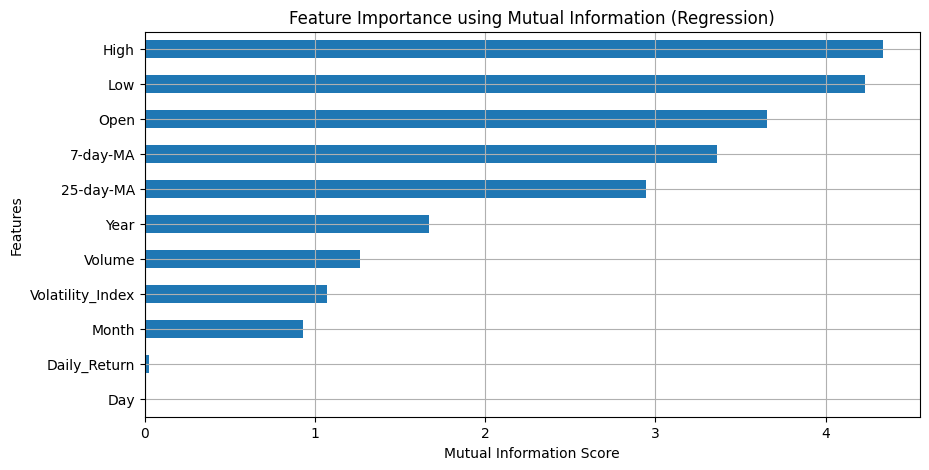

In [8]:
from sklearn.feature_selection import mutual_info_regression

# Compute Mutual Information for Regression
importances = mutual_info_regression(X, y)

# Convert to Series for easy visualization
feat_importances = pd.Series(importances, index=X.columns)

# Plot feature importance
plt.figure(figsize=(10, 5))
feat_importances.sort_values().plot(kind="barh")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance using Mutual Information (Regression)")
plt.grid(True)
plt.show()

In [9]:
X=X.drop(['Year','Day','Daily_Return','Volatility_Index'],axis=1)
X.head(2)

,Open,High,Low,Volume,Month,7-day-MA,25-day-MA
30,226.440994,233.503998,216.309006,23348200,1,243.140429,239.081519
31,216.867004,231.574005,212.014999,29128500,2,239.319571,236.386918


In [10]:
# splitting X and y into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [11]:

model = RandomForestRegressor(n_estimators = 20, random_state = 0)

model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

In [12]:
# Metrics calculation
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, y_pred)))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

# R-squared score
print('R-squared (R²):', r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 286.8464425598549
Mean Squared Error (MSE): 399263.2380708722
Root Mean Squared Error (RMSE): 631.8728021294097
Mean Absolute Percentage Error (MAPE): 1.3657006976044337
R-squared (R²): 0.999267903959272


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

# Grid search with cross-validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=0, n_jobs=-1), 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_absolute_error', 
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [14]:

rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=20,                
    min_samples_split=2,         
    min_samples_leaf=1,          
    random_state=0, 
    n_jobs=-1
)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform cross-validation
cv_results = cross_validate(
    rf_model, X_train, y_train, cv=cv, 
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
    n_jobs=-1, return_train_score=True
)

# Compute training performance (cross-validation mean & std)
mae_train_mean = -cv_results['train_neg_mean_absolute_error'].mean()
mae_train_std = cv_results['train_neg_mean_absolute_error'].std()
mse_train_mean = -cv_results['train_neg_mean_squared_error'].mean()
mse_train_std = cv_results['train_neg_mean_squared_error'].std()
rmse_train_mean = np.sqrt(mse_train_mean)
r2_train_mean = cv_results['train_r2'].mean()

# Compute validation performance
mae_val_mean = -cv_results['test_neg_mean_absolute_error'].mean()
mse_val_mean = -cv_results['test_neg_mean_squared_error'].mean()
rmse_val_mean = np.sqrt(mse_val_mean)
r2_val_mean = cv_results['test_r2'].mean()

# Fit model on full training data and evaluate on test set
rf_model.fit(X_train, y_train)
y_pred_test = rf_model.predict(X_test)

# Calculate test set performance
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

# Print Training & Validation Performance
print(f"Training Performance (5-Fold CV):")
print(f"MAE: {mae_train_mean:.2f} ± {mae_train_std:.2f}")
print(f"MSE: {mse_train_mean:.2f} ± {mse_train_std:.2f}")
print(f"RMSE: {rmse_train_mean:.2f}")
print(f"R²: {r2_train_mean:.4f}")

print(f"\nValidation Performance (5-Fold CV):")
print(f"MAE: {mae_val_mean:.2f}")
print(f"MSE: {mse_val_mean:.2f}")
print(f"RMSE: {rmse_val_mean:.2f}")
print(f"R²: {r2_val_mean:.4f}")

# Print Testing Performance
print("\nTesting Performance:")
print(f"MAE: {mae_test:.2f}")
print(f"MSE: {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²: {r2_test:.4f}")

# Check for Overfitting
overfitting_threshold = 1.10  
mae_ratio = mae_train_mean / mae_test
mse_ratio = mse_train_mean / mse_test

if mae_ratio < overfitting_threshold and mse_ratio < overfitting_threshold:
    print("\nThe model seems to generalize well with balanced training and testing performance.")
else:
    print("\nWarning: Potential Overfitting detected! Training performance is much better than testing performance.")


Training Performance (5-Fold CV):
MAE: 99.66 ± 1.43
MSE: 38621.71 ± 1341.03
RMSE: 196.52
R²: 0.9999

Validation Performance (5-Fold CV):
MAE: 271.62
MSE: 291713.92
RMSE: 540.11
R²: 0.9994

Testing Performance:
MAE: 277.12
MSE: 378460.53
RMSE: 615.19
R²: 0.9993

The model seems to generalize well with balanced training and testing performance.



### Normality Test Results ###

Shapiro-Wilk Test Statistic: 0.656912
P-value: 3.612926e-39
Shapiro-Wilk Test: Reject the null hypothesis (Data is NOT normally distributed).

Kolmogorov-Smirnov Test Statistic: 0.237049
P-value: 2.838943e-45
Kolmogorov-Smirnov Test: Reject the null hypothesis (Data is NOT normally distributed).

Anderson-Darling Test Statistic: 99.163891
Critical Values: [0.573 0.653 0.784 0.914 1.087]
Significance Levels: [15.  10.   5.   2.5  1. ]%
Anderson-Darling Test: Reject the null hypothesis (Data is NOT normally distributed).


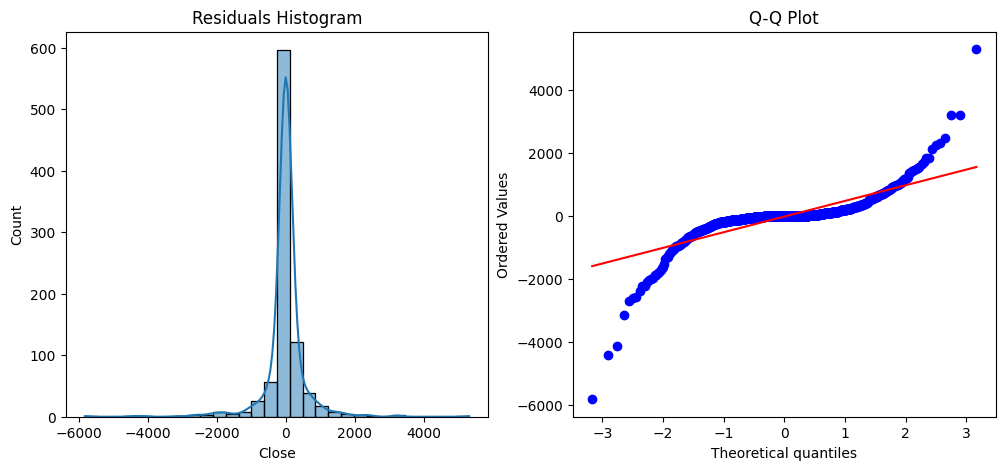

In [16]:
from scipy import stats

residuals = y_test - y_pred_test

# Shapiro-Wilk Test
shapiro_test = stats.shapiro(residuals)
shapiro_stat, shapiro_p = shapiro_test.statistic, shapiro_test.pvalue

#  Kolmogorov-Smirnov (KS) Test
ks_test = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
ks_stat, ks_p = ks_test.statistic, ks_test.pvalue

#  Anderson-Darling Test
ad_test = stats.anderson(residuals, dist='norm')
ad_stat, ad_critical_values, ad_significance = ad_test.statistic, ad_test.critical_values, ad_test.significance_level


print("\n### Normality Test Results ###\n")

# Shapiro-Wilk
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat:.6f}")
print(f"P-value: {shapiro_p:.6e}")
if shapiro_p < 0.05:
    print("Shapiro-Wilk Test: Reject the null hypothesis (Data is NOT normally distributed).")
else:
    print("Shapiro-Wilk Test: Fail to reject the null hypothesis (Data is normally distributed).")

# Kolmogorov-Smirnov
print(f"\nKolmogorov-Smirnov Test Statistic: {ks_stat:.6f}")
print(f"P-value: {ks_p:.6e}")
if ks_p < 0.05:
    print("Kolmogorov-Smirnov Test: Reject the null hypothesis (Data is NOT normally distributed).")
else:
    print("Kolmogorov-Smirnov Test: Fail to reject the null hypothesis (Data is normally distributed).")

# Anderson-Darling
print(f"\nAnderson-Darling Test Statistic: {ad_stat:.6f}")
print(f"Critical Values: {ad_critical_values}")
print(f"Significance Levels: {ad_significance}%")
if any(ad_stat > ad_critical_values[i] for i in range(len(ad_critical_values))):
    print("Anderson-Darling Test: Reject the null hypothesis (Data is NOT normally distributed).")
else:
    print("Anderson-Darling Test: Fail to reject the null hypothesis (Data is normally distributed).")

#  Visualization: Histogram & Q-Q Plot
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Histogram")

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")

plt.show()


In [ ]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(difference)

print(f"Wilcoxon Test Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Significant difference between predicted and actual values.")
else:
    print("Fail to reject the null hypothesis: No significant difference between predicted and actual values.")

Wilcoxon Test Statistic: 201794.0
P-value: 0.64394603079561
Fail to reject the null hypothesis: No significant difference between predicted and actual values.


In [ ]:
# Save the trained model
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [ ]:
X_train.head(1)

,Open,High,Low,Volume,Month,7-day-MA,25-day-MA
1159,11532.400391,11704.099609,11443.900391,6468539904,3,11105.214286,10231.186504


In [ ]:
# Feature names (must match those used during training)
feature_names = ["Open", "High", "Low","Volume","Month", "7-day-MA", "25-day-MA"]

def predict_new_data(new_data):
    # Load the trained model
    model = joblib.load("rf_model.pkl")
    
    # Convert to DataFrame with column names
    new_data_df = pd.DataFrame(new_data, columns=feature_names)
    
    # Make predictions directly
    new_rf_pred = model.predict(new_data_df)
    
    return new_rf_pred  # No need for inverse transformation

# Example Usage
new_data = np.array([[89931.88,	91283.02, 84667.03,	48139.07,3,89145.32, 92571.98]])
rf_prediction = predict_new_data(new_data)
print(f"New Data Prediction - Random Forest: {rf_prediction}")


New Data Prediction - Random Forest: [90839.26976562]
